### 1. Environment Setup and Imports
We begin by configuring environment variables to optimize GPU memory allocation and suppress specific XLA compiler flags. Then, we import the necessary libraries for data manipulation (Pandas, NumPy), visualization (Matplotlib), and deep learning (TensorFlow/Keras). We also set a global random seed to ensure reproducibility.

In [ ]:
import os
import sys
import subprocess
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import mixed_precision

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.regularizers import l2

gpus = tf.config.list_physical_devices('GPU')
has_gpu = len(gpus) > 0
print("GPUs:", gpus)

if has_gpu:
    os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
    os.environ["XLA_FLAGS"] = "--xla_gpu_force_compilation_parallelism=1"
    os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

    mixed_precision.set_global_policy('mixed_float16')
    print("GPU + mixed precision enabled.")
else:
    print("Running on CPU.")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
data_root_path = "/home/user/datasets/rare_species/"
SPLIT_FILE = "fixed_test_split.csv"


2025-12-10 13:50:57.162750: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU + mixed precision enabled.


### 2. Data Loading and Cleaning
Here we load the metadata CSV and construct the full file paths. We perform a validity check to remove any entries where the image file does not exist or the label is missing. Finally, we handle duplicates and stratify the data into Train, Validation, and Test sets to preserve class distribution.

In [ ]:

df = pd.read_csv('../metadata.csv')

df['full_path'] = df['file_path'].apply(lambda x: os.path.join(data_root_path, x))

df = df.dropna(subset=['file_path', 'family']).reset_index(drop=True)

df['exists'] = df['full_path'].apply(os.path.exists)
print(f"Number of missing files: {len(df[df['exists'] == False])}")
df = df[df['exists'] == True].reset_index(drop=True)

df = df.drop_duplicates().reset_index(drop=True)
df = df.drop_duplicates(subset='full_path').reset_index(drop=True)

print(f"Cleaned data: {len(df)} images")
print(f"Number of categories (families): {df['family'].nunique()}")

df['family'] = df['family'].astype(str)

Number of missing files: 0
Cleaned data: 11983 images
Number of categories (families): 202


In [ ]:
if os.path.exists(SPLIT_FILE):
    print(f"\nLoading previous split from: {SPLIT_FILE}")
    
    test_df = pd.read_csv(SPLIT_FILE)
    
    test_df['full_path'] = test_df['file_path'].apply(lambda x: os.path.join(data_root_path, x))
    
    test_df = test_df[test_df['full_path'].apply(os.path.exists)].reset_index(drop=True)
    
    train_val_df = df[~df['file_path'].isin(test_df['file_path'])].reset_index(drop=True)
    
    print("Successfully split based on saved CSV.")

else:
    print("\nNo saved split found. Creating new split...")
    
    train_val_df, test_df = train_test_split(
        df,
        test_size=0.10,
        stratify=df["family"],
        random_state=SEED
    )
    
    test_df.to_csv(SPLIT_FILE, index=False)
    print(f"New split saved to: {SPLIT_FILE}")

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.1111,
    stratify=train_val_df["family"],
    random_state=SEED
)

print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))

Train: 9585
Val: 1199
Test: 1199


## 3. Data Augmentation and Generators
We define the image data generators. The training generator applies strong data augmentation (rotation, shifts, zooms) to prevent overfitting, while the validation and test generators only apply the necessary preprocessing. We then create the data flows using flow_from_dataframe.

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    width_shift_range=0.2,  
    height_shift_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    shear_range=0.15,
    channel_shift_range=20.0,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_ds = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='full_path',
    y_col='family',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)   

val_ds = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='full_path',
    y_col='family',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False 
)

test_ds = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='full_path',
    y_col='family',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 9585 validated image filenames belonging to 202 classes.
Found 1199 validated image filenames belonging to 202 classes.
Found 1199 validated image filenames belonging to 202 classes.


### 4. Handling Class Imbalance
To address potential imbalances in the dataset (some rare species might have fewer images), we compute class weights. These weights will be passed to the model during training to penalize mistakes on minority classes more heavily.

In [ ]:
labels = train_ds.classes
weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(weights))
print(class_weights)

{0: np.float64(0.49947889525794686), 1: np.float64(0.6590346534653465), 2: np.float64(0.28244342291371993), 3: np.float64(0.9885519801980198), 4: np.float64(0.4942759900990099), 5: np.float64(1.9771039603960396), 6: np.float64(1.9771039603960396), 7: np.float64(1.9771039603960396), 8: np.float64(0.9885519801980198), 9: np.float64(0.9885519801980198), 10: np.float64(0.32951732673267325), 11: np.float64(0.9885519801980198), 12: np.float64(0.9885519801980198), 13: np.float64(0.39542079207920794), 14: np.float64(0.9885519801980198), 15: np.float64(1.9771039603960396), 16: np.float64(0.39542079207920794), 17: np.float64(1.9771039603960396), 18: np.float64(1.9771039603960396), 19: np.float64(1.9771039603960396), 20: np.float64(1.9771039603960396), 21: np.float64(0.9885519801980198), 22: np.float64(1.9771039603960396), 23: np.float64(0.24713799504950495), 24: np.float64(1.9771039603960396), 25: np.float64(0.28244342291371993), 26: np.float64(0.39542079207920794), 27: np.float64(0.988551980198

### 5. Model Architecture (Transfer Learning)
We define a function to build the model using EfficientNetB0 as the backbone. We initialize it with ImageNet weights, freeze the base layers (to preserve learned features), and add a custom classification head with Global Average Pooling, Dropout for regularization, and a final Softmax layer.

In [ ]:
def build_model(num_classes):
    base_model = EfficientNetB0(
        include_top=False, 
        weights='imagenet', 
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
    )
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)
    
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model, base_model

num_classes = len(train_ds.class_indices)
model, base_model = build_model(num_classes)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1765301253.205967   44262 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1765301253.209984   44262 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,429,421 (16.90 MB)

 Trainable params: 379,850 (1.45 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

### 6. Phase 1 Training (Warmup)
We train only the custom head layers for 20 epochs. Callbacks are used to save the best model weights, stop early if validation loss stops improving, and reduce the learning rate when the model plateaus.

In [ ]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
checkpoint1 = ModelCheckpoint("best_phase1_new.h5", save_best_only=True)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

history_1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint1, reduce_lr]
)

Epoch 1/20


2025-12-08 22:35:20.774415: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f7008005e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-08 22:35:20.774559: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-12-08 22:35:21.311969: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-08 22:35:24.664069: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
2025-12-08 22:35:26.775215: W external/local_xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1008] Compiling 19 configs for 5 fusions on a single thread.
2025-12-08 22:35:42.302261: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=0} for conv (f32[16,480,14,14]{3,2,1,0}, u8[0]{0}) custom-call(

488/600 ━━━━━━━━━━━━━━━━━━━━ 1:06 595ms/step - accuracy: 0.1134 - loss: 4.7972

2025-12-08 22:41:08.316376: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-08 22:41:08.916673: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=0} for conv (f32[1,672,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,672,14,14]{3,2,1,0}, f32[672,1,5,5]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, feature_group_count=672, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2025-12-08 22:41:09.454841: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optim

600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.1305 - loss: 4.6362

2025-12-08 22:42:46.102316: W external/local_xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1008] Compiling 9 configs for 2 fusions on a single thread.
/home/user/tf_gpu_test/.venv/lib/python3.12/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
2025-12-08 22:43:27.713731: W external/local_xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1008] Compiling 9 configs for 2 fusions on a single thread.
2025-12-08 22:43:41.452646: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-08 22:43:41.694607: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in 

600/600 ━━━━━━━━━━━━━━━━━━━━ 532s 792ms/step - accuracy: 0.2160 - loss: 3.8266 - val_accuracy: 0.4512 - val_loss: 2.1524 - learning_rate: 0.0010
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.3986 - loss: 2.3210

600/600 ━━━━━━━━━━━━━━━━━━━━ 402s 669ms/step - accuracy: 0.4128 - loss: 2.2631 - val_accuracy: 0.5421 - val_loss: 1.8029 - learning_rate: 0.0010
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.4826 - loss: 1.8731

600/600 ━━━━━━━━━━━━━━━━━━━━ 451s 752ms/step - accuracy: 0.4937 - loss: 1.8596 - val_accuracy: 0.5755 - val_loss: 1.6511 - learning_rate: 0.0010
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.5419 - loss: 1.6215

600/600 ━━━━━━━━━━━━━━━━━━━━ 428s 712ms/step - accuracy: 0.5351 - loss: 1.6705 - val_accuracy: 0.5897 - val_loss: 1.5738 - learning_rate: 0.0010
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 404s 674ms/step - accuracy: 0.5573 - loss: 1.5624 - val_accuracy: 0.6013 - val_loss: 1.6010 - learning_rate: 0.0010
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 424s 706ms/step - accuracy: 0.5845 - loss: 1.4535 - val_accuracy: 0.6155 - val_loss: 1.5751 - learning_rate: 0.0010
Epoch 7/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 838ms/step - accuracy: 0.6100 - loss: 1.3049

600/600 ━━━━━━━━━━━━━━━━━━━━ 553s 921ms/step - accuracy: 0.5979 - loss: 1.3641 - val_accuracy: 0.6038 - val_loss: 1.5686 - learning_rate: 0.0010
Epoch 8/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.6036 - loss: 1.3140

600/600 ━━━━━━━━━━━━━━━━━━━━ 431s 719ms/step - accuracy: 0.6028 - loss: 1.3558 - val_accuracy: 0.6355 - val_loss: 1.5406 - learning_rate: 0.0010
Epoch 9/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 423s 704ms/step - accuracy: 0.6154 - loss: 1.3214 - val_accuracy: 0.6247 - val_loss: 1.5451 - learning_rate: 0.0010
Epoch 10/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 380s 634ms/step - accuracy: 0.6286 - loss: 1.2746 - val_accuracy: 0.6414 - val_loss: 1.6011 - learning_rate: 0.0010
Epoch 11/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.6343 - loss: 1.2103
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
600/600 ━━━━━━━━━━━━━━━━━━━━ 367s 611ms/step - accuracy: 0.6348 - loss: 1.2497 - val_accuracy: 0.6397 - val_loss: 1.5583 - learning_rate: 0.0010
Epoch 12/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.6665 - loss: 1.0949

600/600 ━━━━━━━━━━━━━━━━━━━━ 380s 632ms/step - accuracy: 0.6727 - loss: 1.0830 - val_accuracy: 0.6614 - val_loss: 1.4944 - learning_rate: 3.0000e-04
Epoch 13/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 367s 611ms/step - accuracy: 0.6965 - loss: 0.9996 - val_accuracy: 0.6614 - val_loss: 1.4962 - learning_rate: 3.0000e-04
Epoch 14/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.7010 - loss: 1.0160

600/600 ━━━━━━━━━━━━━━━━━━━━ 357s 596ms/step - accuracy: 0.6949 - loss: 1.0110 - val_accuracy: 0.6664 - val_loss: 1.4696 - learning_rate: 3.0000e-04
Epoch 15/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 348s 579ms/step - accuracy: 0.6964 - loss: 0.9769 - val_accuracy: 0.6639 - val_loss: 1.4816 - learning_rate: 3.0000e-04
Epoch 16/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 365s 608ms/step - accuracy: 0.7091 - loss: 0.9615 - val_accuracy: 0.6664 - val_loss: 1.4777 - learning_rate: 3.0000e-04
Epoch 17/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.7110 - loss: 0.9115
Epoch 17: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
600/600 ━━━━━━━━━━━━━━━━━━━━ 362s 600ms/step - accuracy: 0.7154 - loss: 0.9223 - val_accuracy: 0.6747 - val_loss: 1.4703 - learning_rate: 3.0000e-04
Epoch 18/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.7158 - loss: 0.9106

600/600 ━━━━━━━━━━━━━━━━━━━━ 361s 602ms/step - accuracy: 0.7184 - loss: 0.8971 - val_accuracy: 0.6764 - val_loss: 1.4525 - learning_rate: 9.0000e-05
Epoch 19/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.7330 - loss: 0.8780

600/600 ━━━━━━━━━━━━━━━━━━━━ 351s 584ms/step - accuracy: 0.7253 - loss: 0.8919 - val_accuracy: 0.6764 - val_loss: 1.4502 - learning_rate: 9.0000e-05
Epoch 20/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.7428 - loss: 0.8416

600/600 ━━━━━━━━━━━━━━━━━━━━ 378s 578ms/step - accuracy: 0.7328 - loss: 0.8659 - val_accuracy: 0.6764 - val_loss: 1.4422 - learning_rate: 9.0000e-05


### 7. Visualization Helper
This helper function plots the training and validation accuracy and loss curves, allowing us to visually inspect the model's performance and check for overfitting.

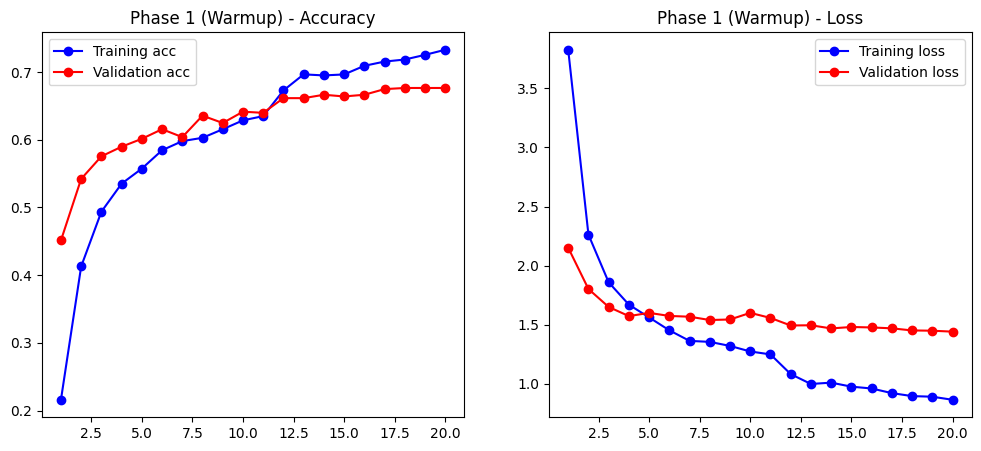

In [ ]:
def plot_history(hist, phase_name):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
    plt.title(f'{phase_name} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title(f'{phase_name} - Loss')
    plt.legend()
    
    plt.show()

plot_history(history_1, "Phase 1 (Warmup)")

### 8. Phase 2 Training (Fine-tuning)
Now we unfreeze the last 60 layers of the EfficientNet base model to fine-tune the feature extractors to our specific dataset. We use a much lower learning rate (1e-5) to avoid destroying the pre-trained weights and keep Batch Normalization layers frozen to maintain stability.

In [ ]:
model.load_weights("best_phase1_new.h5")
base_model.trainable = True

for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

for layer in base_model.layers[:-60]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

checkpoint2 = ModelCheckpoint("best_final_model_new.h5", save_best_only=True)
early_stop = EarlyStopping(patience=9, restore_best_weights=True)
reduce_lr2 = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

history_2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint2, reduce_lr2]
)

Epoch 1/30


2025-12-09 11:52:08.630119: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-09 11:52:08.929532: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-09 11:52:09.188290: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-09 11:52:09.222260: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=0} for conv (f32[16,672,17,17]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,672,21,21]{3,2,1,0}, f32[672,1,5,5]{3,2,1,0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, feature_group_co

488/600 ━━━━━━━━━━━━━━━━━━━━ 1:12 643ms/step - accuracy: 0.5167 - loss: 1.9764

2025-12-09 11:58:06.304989: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-09 11:58:06.534807: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - accuracy: 0.5185 - loss: 1.9594

/home/user/tf_gpu_test/.venv/lib/python3.12/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


600/600 ━━━━━━━━━━━━━━━━━━━━ 569s 827ms/step - accuracy: 0.5288 - loss: 1.8786 - val_accuracy: 0.6447 - val_loss: 1.5918 - learning_rate: 1.0000e-05
Epoch 2/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.5619 - loss: 1.6822

600/600 ━━━━━━━━━━━━━━━━━━━━ 436s 726ms/step - accuracy: 0.5693 - loss: 1.6349 - val_accuracy: 0.6480 - val_loss: 1.5516 - learning_rate: 1.0000e-05
Epoch 3/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.5887 - loss: 1.4877

600/600 ━━━━━━━━━━━━━━━━━━━━ 390s 650ms/step - accuracy: 0.5966 - loss: 1.4652 - val_accuracy: 0.6514 - val_loss: 1.5349 - learning_rate: 1.0000e-05
Epoch 4/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.5956 - loss: 1.4683

600/600 ━━━━━━━━━━━━━━━━━━━━ 381s 635ms/step - accuracy: 0.6014 - loss: 1.4156 - val_accuracy: 0.6539 - val_loss: 1.5251 - learning_rate: 1.0000e-05
Epoch 5/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.6209 - loss: 1.3367

600/600 ━━━━━━━━━━━━━━━━━━━━ 411s 684ms/step - accuracy: 0.6147 - loss: 1.3404 - val_accuracy: 0.6530 - val_loss: 1.5167 - learning_rate: 1.0000e-05
Epoch 6/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.6208 - loss: 1.3056

600/600 ━━━━━━━━━━━━━━━━━━━━ 402s 670ms/step - accuracy: 0.6233 - loss: 1.3125 - val_accuracy: 0.6572 - val_loss: 1.4987 - learning_rate: 1.0000e-05
Epoch 7/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.6285 - loss: 1.2783

600/600 ━━━━━━━━━━━━━━━━━━━━ 460s 766ms/step - accuracy: 0.6241 - loss: 1.2901 - val_accuracy: 0.6564 - val_loss: 1.4967 - learning_rate: 1.0000e-05
Epoch 8/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.6354 - loss: 1.2416

600/600 ━━━━━━━━━━━━━━━━━━━━ 431s 718ms/step - accuracy: 0.6328 - loss: 1.2536 - val_accuracy: 0.6589 - val_loss: 1.4889 - learning_rate: 1.0000e-05
Epoch 9/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.6425 - loss: 1.2385

600/600 ━━━━━━━━━━━━━━━━━━━━ 416s 693ms/step - accuracy: 0.6381 - loss: 1.2212 - val_accuracy: 0.6622 - val_loss: 1.4868 - learning_rate: 1.0000e-05
Epoch 10/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.6453 - loss: 1.1730

600/600 ━━━━━━━━━━━━━━━━━━━━ 408s 681ms/step - accuracy: 0.6465 - loss: 1.1670 - val_accuracy: 0.6697 - val_loss: 1.4743 - learning_rate: 1.0000e-05
Epoch 11/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 420s 700ms/step - accuracy: 0.6476 - loss: 1.1885 - val_accuracy: 0.6614 - val_loss: 1.4774 - learning_rate: 1.0000e-05
Epoch 12/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 463s 771ms/step - accuracy: 0.6602 - loss: 1.1375 - val_accuracy: 0.6580 - val_loss: 1.4759 - learning_rate: 1.0000e-05
Epoch 13/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.6578 - loss: 1.1297

600/600 ━━━━━━━━━━━━━━━━━━━━ 442s 736ms/step - accuracy: 0.6621 - loss: 1.1220 - val_accuracy: 0.6631 - val_loss: 1.4679 - learning_rate: 1.0000e-05
Epoch 14/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.6641 - loss: 1.1171

600/600 ━━━━━━━━━━━━━━━━━━━━ 420s 700ms/step - accuracy: 0.6628 - loss: 1.1149 - val_accuracy: 0.6672 - val_loss: 1.4661 - learning_rate: 1.0000e-05
Epoch 15/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - accuracy: 0.6695 - loss: 1.0662

600/600 ━━━━━━━━━━━━━━━━━━━━ 493s 821ms/step - accuracy: 0.6625 - loss: 1.1020 - val_accuracy: 0.6631 - val_loss: 1.4607 - learning_rate: 1.0000e-05
Epoch 16/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 427s 711ms/step - accuracy: 0.6692 - loss: 1.0924 - val_accuracy: 0.6647 - val_loss: 1.4626 - learning_rate: 1.0000e-05
Epoch 17/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.6685 - loss: 1.0780

600/600 ━━━━━━━━━━━━━━━━━━━━ 281s 468ms/step - accuracy: 0.6644 - loss: 1.0884 - val_accuracy: 0.6706 - val_loss: 1.4554 - learning_rate: 1.0000e-05
Epoch 18/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.6746 - loss: 1.0915

600/600 ━━━━━━━━━━━━━━━━━━━━ 279s 464ms/step - accuracy: 0.6719 - loss: 1.0776 - val_accuracy: 0.6697 - val_loss: 1.4515 - learning_rate: 1.0000e-05
Epoch 19/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.6700 - loss: 1.1061

600/600 ━━━━━━━━━━━━━━━━━━━━ 270s 449ms/step - accuracy: 0.6722 - loss: 1.0793 - val_accuracy: 0.6689 - val_loss: 1.4480 - learning_rate: 1.0000e-05
Epoch 20/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.6776 - loss: 1.0453

600/600 ━━━━━━━━━━━━━━━━━━━━ 273s 455ms/step - accuracy: 0.6803 - loss: 1.0380 - val_accuracy: 0.6706 - val_loss: 1.4412 - learning_rate: 1.0000e-05
Epoch 21/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.6836 - loss: 1.0003

600/600 ━━━━━━━━━━━━━━━━━━━━ 278s 463ms/step - accuracy: 0.6818 - loss: 1.0304 - val_accuracy: 0.6781 - val_loss: 1.4382 - learning_rate: 1.0000e-05
Epoch 22/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.6844 - loss: 1.0050

600/600 ━━━━━━━━━━━━━━━━━━━━ 401s 668ms/step - accuracy: 0.6874 - loss: 1.0090 - val_accuracy: 0.6789 - val_loss: 1.4340 - learning_rate: 1.0000e-05
Epoch 23/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 371s 617ms/step - accuracy: 0.6875 - loss: 1.0161 - val_accuracy: 0.6781 - val_loss: 1.4377 - learning_rate: 1.0000e-05
Epoch 24/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 378s 630ms/step - accuracy: 0.6894 - loss: 1.0083 - val_accuracy: 0.6747 - val_loss: 1.4396 - learning_rate: 1.0000e-05
Epoch 25/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.6923 - loss: 0.9735

600/600 ━━━━━━━━━━━━━━━━━━━━ 358s 597ms/step - accuracy: 0.6995 - loss: 0.9610 - val_accuracy: 0.6797 - val_loss: 1.4323 - learning_rate: 1.0000e-05
Epoch 26/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.7027 - loss: 0.9690

600/600 ━━━━━━━━━━━━━━━━━━━━ 355s 592ms/step - accuracy: 0.6995 - loss: 0.9727 - val_accuracy: 0.6797 - val_loss: 1.4275 - learning_rate: 1.0000e-05
Epoch 27/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.6960 - loss: 0.9948

600/600 ━━━━━━━━━━━━━━━━━━━━ 359s 597ms/step - accuracy: 0.6965 - loss: 0.9788 - val_accuracy: 0.6872 - val_loss: 1.4237 - learning_rate: 1.0000e-05
Epoch 28/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.6975 - loss: 0.9743

600/600 ━━━━━━━━━━━━━━━━━━━━ 357s 593ms/step - accuracy: 0.7012 - loss: 0.9498 - val_accuracy: 0.6822 - val_loss: 1.4229 - learning_rate: 1.0000e-05
Epoch 29/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.6949 - loss: 0.9620

600/600 ━━━━━━━━━━━━━━━━━━━━ 378s 629ms/step - accuracy: 0.6990 - loss: 0.9665 - val_accuracy: 0.6806 - val_loss: 1.4169 - learning_rate: 1.0000e-05
Epoch 30/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 359s 598ms/step - accuracy: 0.7105 - loss: 0.9282 - val_accuracy: 0.6814 - val_loss: 1.4192 - learning_rate: 1.0000e-05


### 9. Visualizing Fine-tuning Results
We plot the history again to analyze the performance of the fine-tuning phase.

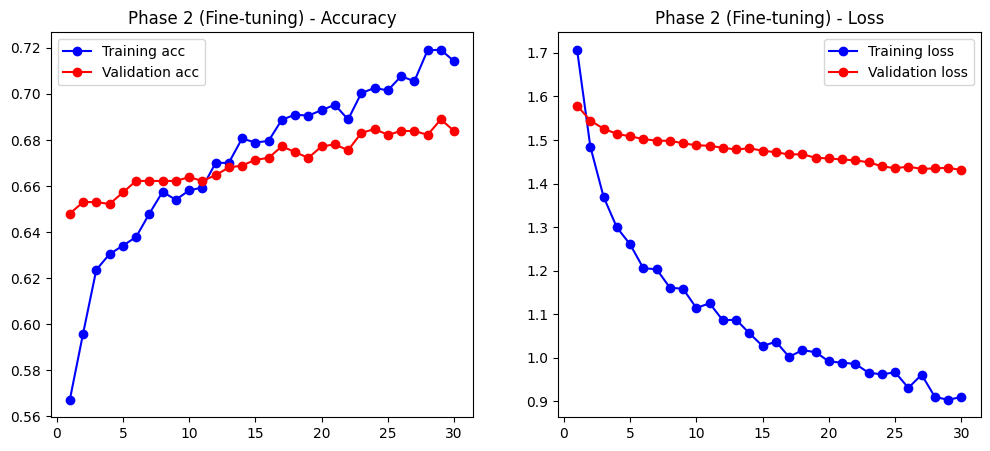

In [ ]:
def plot_history(hist, phase_name):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
    plt.title(f'{phase_name} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title(f'{phase_name} - Loss')
    plt.legend()
    
    plt.show()

plot_history(history_2, "Phase 2 (Fine-tuning)")

### 10. Initial Model Evaluation
We evaluate the model on the test set, calculating F1-scores (Macro, Micro, and Weighted) and overall accuracy to establish a baseline performance before deeper data cleaning.

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

model.load_weights("best_final_model_new.h5")

y_true = test_ds.classes
y_pred_proba = model.predict(test_ds)
y_pred = np.argmax(y_pred_proba, axis=1)

macro_f1 = f1_score(y_true, y_pred, average="macro")
micro_f1 = f1_score(y_true, y_pred, average="micro")
weighted_f1 = f1_score(y_true, y_pred, average="weighted")

print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Micro F1-score: {micro_f1:.4f}")
print(f"Weighted F1-score: {weighted_f1:.4f}")

test_loss, test_acc = model.evaluate(test_ds)
print(f"Final Test Accuracy: {test_acc*100:.2f}%")

2025-12-09 17:28:34.795858: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f9b20004dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-09 17:28:34.795974: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-12-09 17:28:35.016779: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-09 17:28:36.199299: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
2025-12-09 17:28:36.458610: W external/local_xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1008] Compiling 9 configs for 2 fusions on a single thread.
2025-12-09 17:28:51.204922: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing 

74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step

2025-12-09 17:29:32.586614: W external/local_xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1008] Compiling 9 configs for 2 fusions on a single thread.
2025-12-09 17:29:41.863712: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-09 17:29:42.228525: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-09 17:29:42.319613: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-09 17:29:42.640345: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=0} for conv (f32[15

75/75 ━━━━━━━━━━━━━━━━━━━━ 85s 752ms/step
Macro F1-score: 0.7105
Micro F1-score: 0.7198
Weighted F1-score: 0.7193
75/75 ━━━━━━━━━━━━━━━━━━━━ 45s 444ms/step - accuracy: 0.7198 - loss: 1.3425
Final Test Accuracy: 71.98%


### 11. Identifying Bad Data (High Loss Analysis)
To improve model quality, we identify "suspicious" training samples. We calculate the loss for every image in the training set; images with the highest loss are likely mislabeled, blurry, or outliers. We save the top 200 highest-loss samples to a CSV for manual inspection.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


clean_train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_eval_ds = clean_train_datagen.flow_from_dataframe(
    dataframe=train_val_df,
    x_col="full_path",
    y_col="family",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


y_true_indices = train_eval_ds.classes
num_classes = len(train_eval_ds.class_indices)

y_true_onehot = tf.keras.utils.to_categorical(y_true_indices, num_classes=num_classes)

y_pred_proba = model.predict(train_eval_ds, verbose=1)

y_pred_indices = np.argmax(y_pred_proba, axis=1)
y_pred_conf = np.max(y_pred_proba, axis=1)

per_sample_loss = tf.keras.losses.categorical_crossentropy(
    y_true_onehot, y_pred_proba
).numpy()

index_to_class = {v: k for k, v in train_eval_ds.class_indices.items()}

loss_df = pd.DataFrame({
    "image_path": train_eval_ds.filepaths,
    "true_label_index": y_true_indices,
    "true_label_name": [index_to_class[i] for i in y_true_indices],
    "pred_label_index": y_pred_indices,
    "pred_label_name": [index_to_class[i] for i in y_pred_indices],
    "pred_confidence": y_pred_conf,
    "loss": per_sample_loss,
})

loss_df_sorted = loss_df.sort_values(by="loss", ascending=False)

TOP_K = 200
top_k_df = loss_df_sorted.head(TOP_K)

output_path = "high_loss_train_samples_top200.csv"
top_k_df.to_csv(output_path, index=False)

print(f"Saved top {TOP_K} high-loss training samples to: {output_path}")
print(top_k_df.head(5))


Found 10695 validated image filenames belonging to 202 classes.


/home/user/tf_gpu_test/.venv/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py:918: UserWarning: Found 89 invalid image filename(s) in x_col="full_path". These filename(s) will be ignored.
  warnings.warn(


 990/1070 ━━━━━━━━━━━━━━━━━━━━ 24s 308ms/step

/home/user/tf_gpu_test/.venv/lib/python3.12/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1070/1070 ━━━━━━━━━━━━━━━━━━━━ 328s 306ms/step
Saved top 200 high-loss training samples to: high_loss_train_samples_top200.csv
                                              image_path  true_label_index  \
10417  /home/user/datasets/rare_species/chordata_phas...               135   
5057   /home/user/datasets/rare_species/chordata_brac...                24   
10609  /home/user/datasets/rare_species/chordata_hemi...                93   
1129   /home/user/datasets/rare_species/arthropoda_pi...               139   
5528   /home/user/datasets/rare_species/chordata_chel...                46   

         true_label_name  pred_label_index  pred_label_name  pred_confidence  \
10417        phasianidae               169       serranidae         0.401433   
5057   brachypteraciidae                38  cercopithecidae         0.331509   
10609     hemiscylliidae                21       balistidae         0.695472   
1129          pisauridae                60      dactyloidae         0.741604   
5528

### 12. Interactive Data Cleaning Tool
This is a manual review script. It iterates through the high-loss images identified in the previous step, displaying them along with their predicted and actual labels. The user can press 'd' to delete the file (removing bad data) or 'Enter' to keep it.

Loaded 200 suspicious images.
Controls:
  ENTER  -> next image
  d      -> DELETE image
  q      -> quit



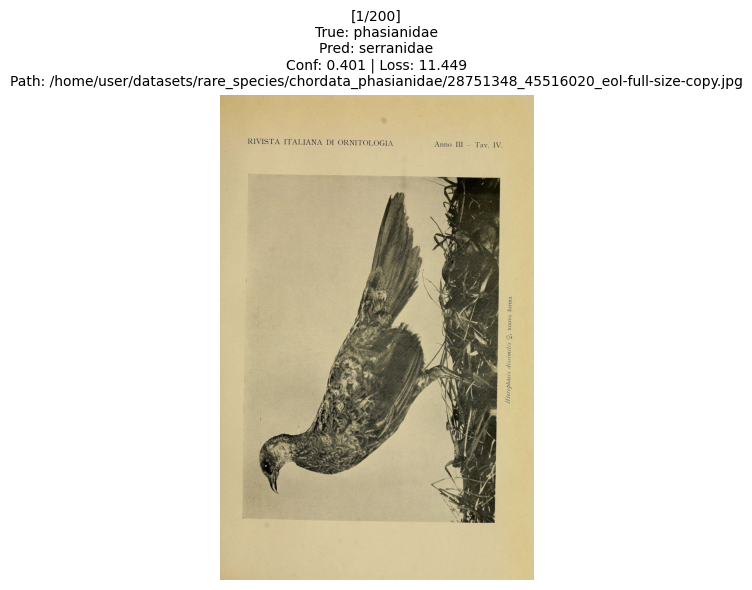

Next...



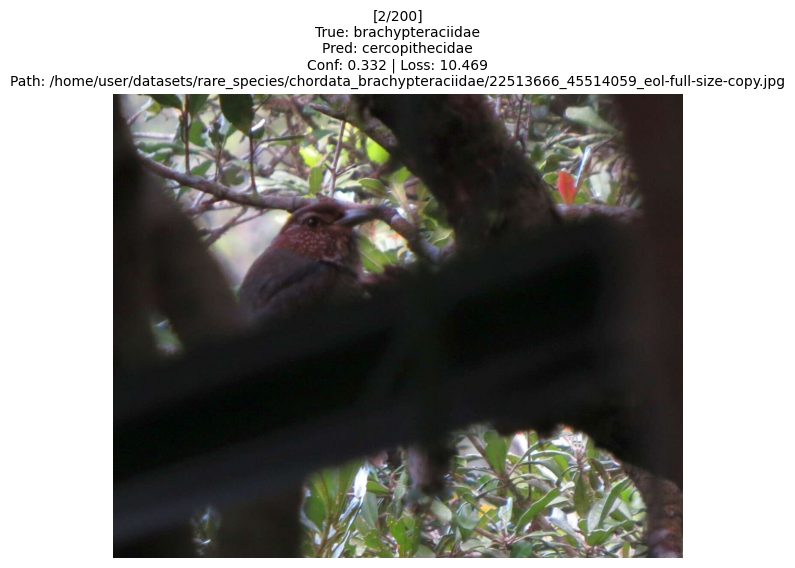

Next...



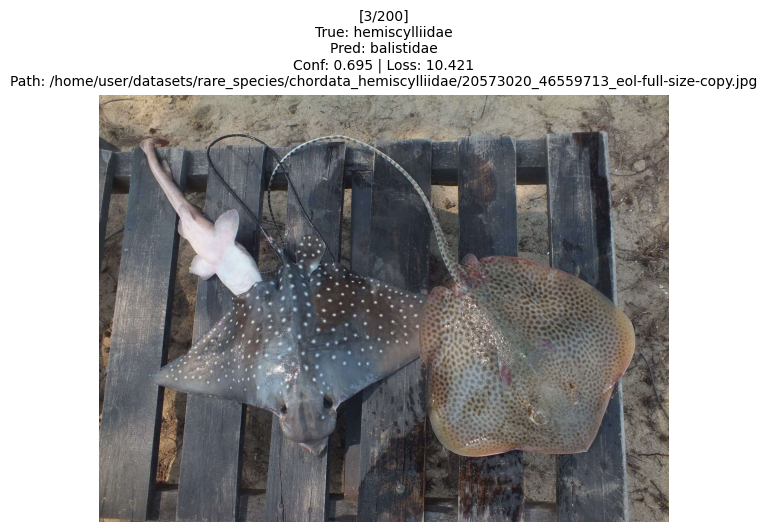

Next...



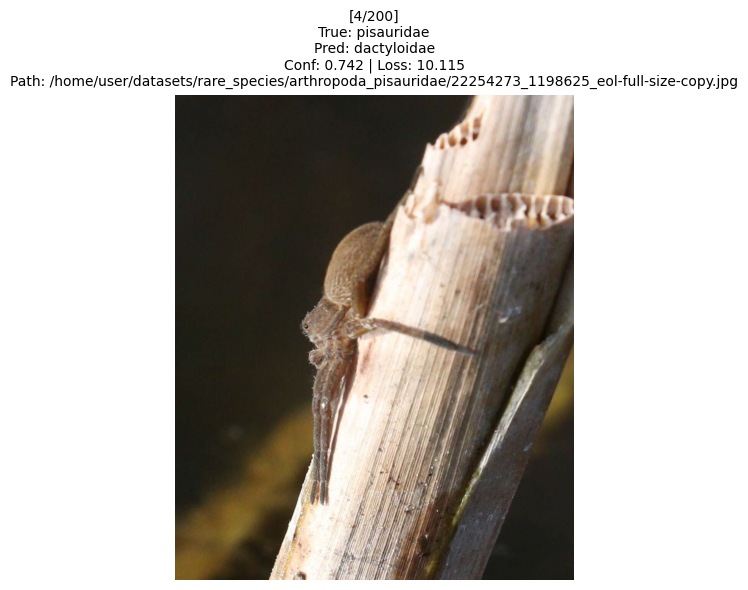

Next...



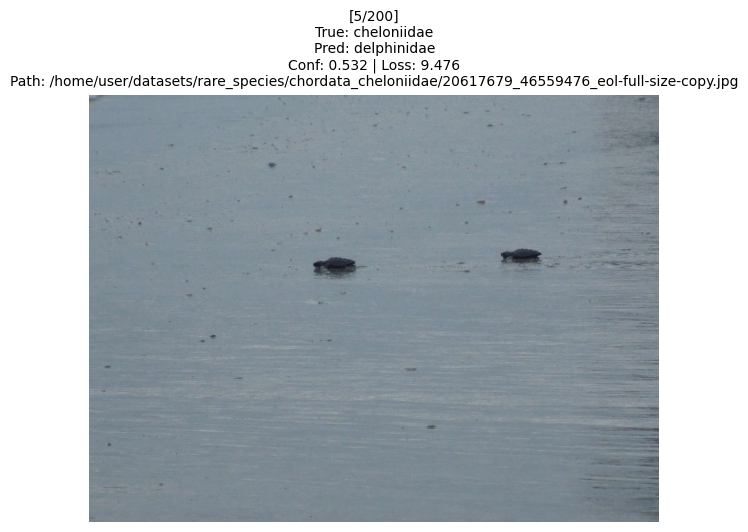

Next...



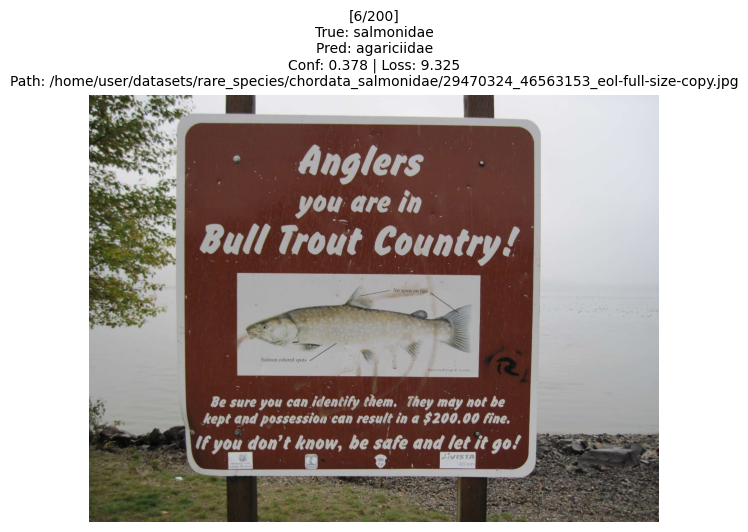

Next...



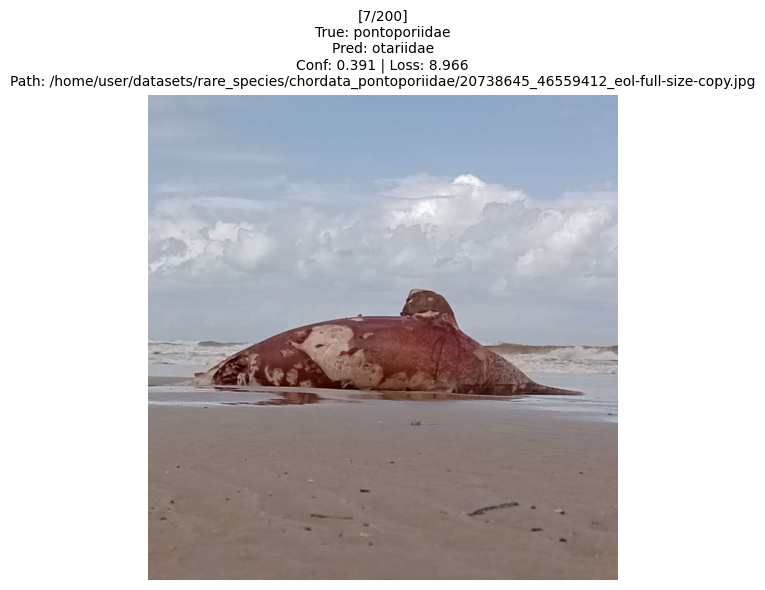

Next...



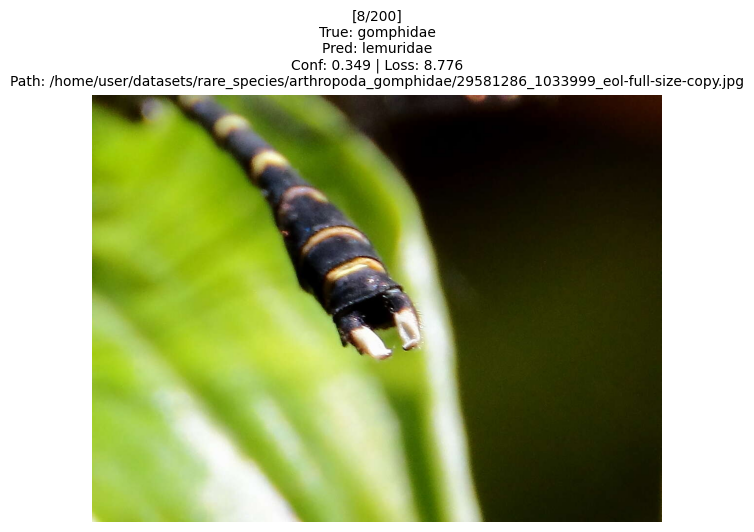

Next...



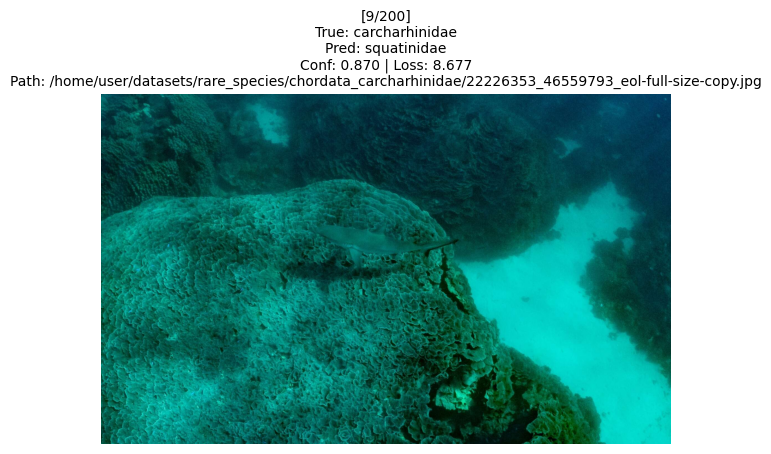

Next...



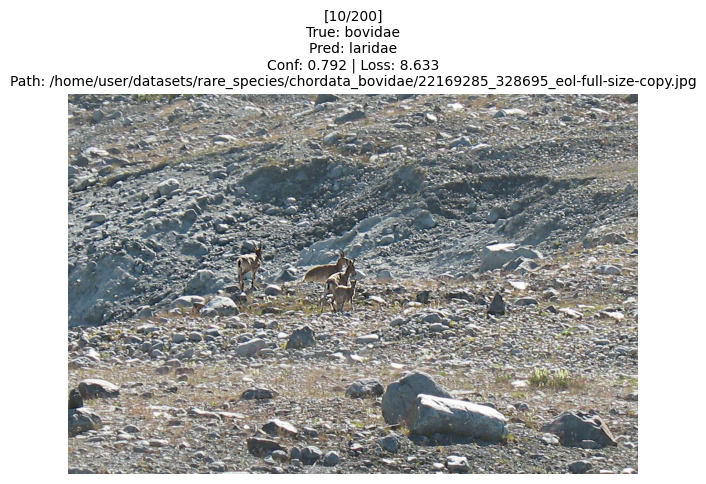

Next...



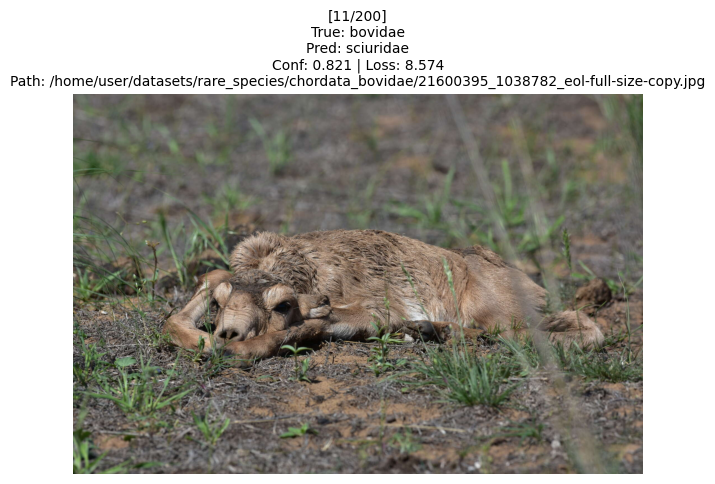

Next...



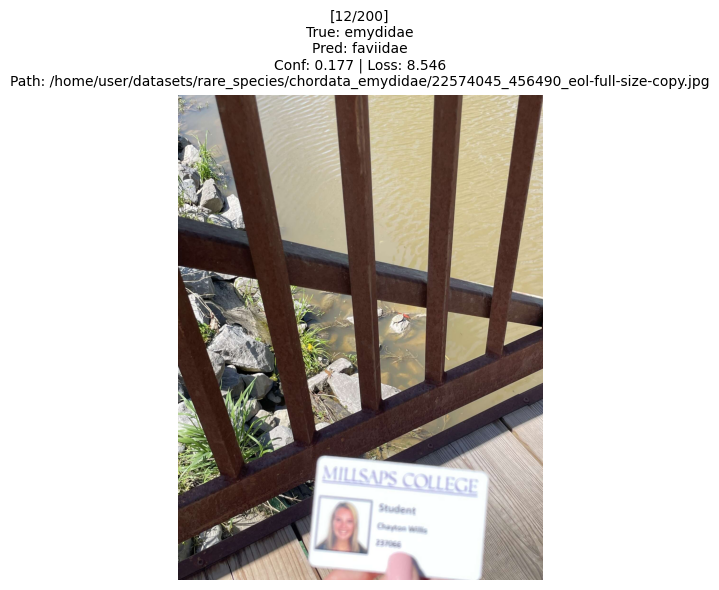

DELETED: /home/user/datasets/rare_species/chordata_emydidae/22574045_456490_eol-full-size-copy.jpg



Next...

Finished review.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os

CSV_PATH = "high_loss_train_samples_top200.csv"

df = pd.read_csv(CSV_PATH)

print(f"Loaded {len(df)} suspicious images.")
print("Controls:")
print("  ENTER  -> next image")
print("  d      -> DELETE image")
print("  q      -> quit\n")

for idx, row in df.iterrows():
    img_path = row["image_path"]

    if not os.path.exists(img_path):
        print(f"File not found, skipping: {img_path}")
        continue

    img = Image.open(img_path).convert("RGB")

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")

    title = (
        f"[{idx+1}/{len(df)}]\n"
        f"True: {row['true_label_name']}\n"
        f"Pred: {row['pred_label_name']}\n"
        f"Conf: {row['pred_confidence']:.3f} | "
        f"Loss: {row['loss']:.3f}\n"
        f"Path: {img_path}"
    )
    plt.title(title, fontsize=10)
    plt.tight_layout()
    plt.show(block=False)

    key = input("ENTER = next | d = delete | q = quit : ").strip().lower()

    plt.close()

    if key == "d":
        try:
            os.remove(img_path)
            print(f"DELETED: {img_path}\n")
        except Exception as e:
            print(f"Could not delete file: {e}\n")

    elif key == "q":
        print("Exiting viewer.")
        break

    else:
        print("Next...\n")

print("Finished review.")


### 13. Re-Initialization for Retraining
After cleaning the data, we essentially restart the pipeline. We re-import libraries and re-load the dataset. Crucially, the code checks os.path.exists again, so the files deleted in the previous step are automatically excluded from the new training set.

In [ ]:
import os
import sys
import subprocess
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import mixed_precision

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.regularizers import l2

gpus = tf.config.list_physical_devices('GPU')
has_gpu = len(gpus) > 0
print("GPUs:", gpus)

if has_gpu:
    os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
    os.environ["XLA_FLAGS"] = "--xla_gpu_force_compilation_parallelism=1"
    os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

    mixed_precision.set_global_policy('mixed_float16')
    print("GPU + mixed precision enabled.")
else:
    print("Running on CPU.")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
data_root_path = "/home/user/datasets/rare_species/"
SPLIT_FILE = "fixed_test_split.csv"

2025-12-10 09:02:40.692817: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
df = pd.read_csv("../metadata.csv")
df["full_path"] = df["file_path"].apply(lambda x: os.path.join(data_root_path, x))

df["exists"] = df["full_path"].apply(os.path.exists)
df = df[df["exists"] == True]

test_df = pd.read_csv(SPLIT_FILE)
test_df["full_path"] = test_df["file_path"].apply(lambda x: os.path.join(data_root_path, x))
test_df = test_df[test_df["full_path"].apply(os.path.exists)]

train_val_df = df[~df["file_path"].isin(test_df["file_path"])]

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.1111,
    stratify=train_val_df["family"],
    random_state=SEED
)

test_df = test_df

print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))

Train: 9476
Val: 1185
Test: 1199


### 14. Re-creating Generators
We rebuild the image generators for the cleaned dataset. The parameters remain the same, but the underlying data now lacks the noisy samples removed in the review step.

In [4]:
from tensorflow.keras.applications.efficientnet import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    width_shift_range=0.2,  
    height_shift_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    shear_range=0.15,
    channel_shift_range=20.0,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_ds = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='full_path',
    y_col='family',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)   

val_ds = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='full_path',
    y_col='family',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False 
)

test_ds = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='full_path',
    y_col='family',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 9476 validated image filenames belonging to 202 classes.
Found 1185 validated image filenames belonging to 202 classes.
Found 1199 validated image filenames belonging to 202 classes.


### 15. Recalculating Weights
Since we removed images, the class balance might have shifted slightly. We recalculate the class weights to ensure the loss function remains balanced.

In [5]:
labels = train_ds.classes
weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(weights))
print(class_weights)

{0: np.float64(0.4937988535695675), 1: np.float64(0.6607167759029424), 2: np.float64(0.2877968778472939), 3: np.float64(0.9981040657257215), 4: np.float64(0.48865511551155116), 5: np.float64(2.132313231323132), 6: np.float64(2.0396039603960396), 7: np.float64(1.9546204620462047), 8: np.float64(0.9773102310231023), 9: np.float64(0.9981040657257215), 10: np.float64(0.33993399339933994), 11: np.float64(0.9773102310231023), 12: np.float64(0.9773102310231023), 13: np.float64(0.3909240924092409), 14: np.float64(0.9773102310231023), 15: np.float64(1.9546204620462047), 16: np.float64(0.3942091688160413), 17: np.float64(1.9546204620462047), 18: np.float64(1.9546204620462047), 19: np.float64(1.9546204620462047), 20: np.float64(2.0396039603960396), 21: np.float64(0.9773102310231023), 22: np.float64(1.9546204620462047), 23: np.float64(0.2535723842654536), 24: np.float64(1.9546204620462047), 25: np.float64(0.2843084308430843), 26: np.float64(0.40440423352680094), 27: np.float64(0.9773102310231023),

### 16. Re-building the Model
We instantiate a fresh EfficientNetB0 model. We do not load the old weights because we want to see if training from scratch (or rather, from ImageNet weights) on the clean data yields better results.

In [6]:
def build_model(num_classes):
    base_model = EfficientNetB0(
        include_top=False, 
        weights='imagenet', 
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
    )
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)
    
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model, base_model

num_classes = len(train_ds.class_indices)
model, base_model = build_model(num_classes)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1765357392.460251    5367 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1765357392.462848    5367 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,429,421 (16.90 MB)

 Trainable params: 379,850 (1.45 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

### 17. Retraining Phase 1 (Warmup)
We perform the warmup training again on the cleaned dataset, saving the results to a new file best_phase1_clean.h5.

In [10]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
checkpoint1 = ModelCheckpoint("best_phase1_clean.h5", save_best_only=True)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

history_1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint1, reduce_lr]
)

Epoch 1/20


2025-12-09 21:33:18.419704: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f43400072f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-09 21:33:18.420109: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-12-09 21:33:19.174314: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-09 21:33:22.707728: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
2025-12-09 21:33:24.884455: W external/local_xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1008] Compiling 19 configs for 5 fusions on a single thread.
2025-12-09 21:33:33.822902: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng51{k2=2,k13=0,k14=2,k18=1,k23=0} for conv (f16[16,112,112,32]{3,2,1,0

210/593 ━━━━━━━━━━━━━━━━━━━━ 4:04 640ms/step - accuracy: 0.0456 - loss: 5.1858

/home/user/tf_gpu_test/.venv/lib/python3.12/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


479/593 ━━━━━━━━━━━━━━━━━━━━ 1:12 640ms/step - accuracy: 0.1009 - loss: 4.8115

2025-12-09 21:39:36.107153: W external/local_xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1008] Compiling 19 configs for 5 fusions on a single thread.


593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - accuracy: 0.1204 - loss: 4.6565

2025-12-09 21:41:36.240452: W external/local_xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1005] Compiling 2 configs for gemm_fusion_dot.2354 on a single thread.


593/593 ━━━━━━━━━━━━━━━━━━━━ 597s 870ms/step - accuracy: 0.2150 - loss: 3.8952 - val_accuracy: 0.4692 - val_loss: 2.1914 - learning_rate: 0.0010
Epoch 2/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.4108 - loss: 2.2824

593/593 ━━━━━━━━━━━━━━━━━━━━ 410s 690ms/step - accuracy: 0.4180 - loss: 2.2378 - val_accuracy: 0.5325 - val_loss: 1.8337 - learning_rate: 0.0010
Epoch 3/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.4838 - loss: 1.8626

593/593 ━━━━━━━━━━━━━━━━━━━━ 549s 927ms/step - accuracy: 0.4902 - loss: 1.8560 - val_accuracy: 0.5890 - val_loss: 1.6252 - learning_rate: 0.0010
Epoch 4/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.5392 - loss: 1.6139

593/593 ━━━━━━━━━━━━━━━━━━━━ 439s 739ms/step - accuracy: 0.5352 - loss: 1.6250 - val_accuracy: 0.6051 - val_loss: 1.5471 - learning_rate: 0.0010
Epoch 5/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.5641 - loss: 1.4957

593/593 ━━━━━━━━━━━━━━━━━━━━ 422s 711ms/step - accuracy: 0.5577 - loss: 1.5301 - val_accuracy: 0.6262 - val_loss: 1.5211 - learning_rate: 0.0010
Epoch 6/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.5862 - loss: 1.3832

593/593 ━━━━━━━━━━━━━━━━━━━━ 283s 477ms/step - accuracy: 0.5820 - loss: 1.4298 - val_accuracy: 0.6388 - val_loss: 1.5031 - learning_rate: 0.0010
Epoch 7/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 254s 428ms/step - accuracy: 0.5986 - loss: 1.3753 - val_accuracy: 0.6346 - val_loss: 1.5147 - learning_rate: 0.0010
Epoch 8/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.6078 - loss: 1.3075

593/593 ━━━━━━━━━━━━━━━━━━━━ 353s 595ms/step - accuracy: 0.6089 - loss: 1.3165 - val_accuracy: 0.6380 - val_loss: 1.4996 - learning_rate: 0.0010
Epoch 9/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.6214 - loss: 1.2318

593/593 ━━━━━━━━━━━━━━━━━━━━ 449s 756ms/step - accuracy: 0.6206 - loss: 1.2744 - val_accuracy: 0.6565 - val_loss: 1.4715 - learning_rate: 0.0010
Epoch 10/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 445s 749ms/step - accuracy: 0.6368 - loss: 1.2391 - val_accuracy: 0.6295 - val_loss: 1.5423 - learning_rate: 0.0010
Epoch 11/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 404s 681ms/step - accuracy: 0.6480 - loss: 1.2034 - val_accuracy: 0.6599 - val_loss: 1.4846 - learning_rate: 0.0010
Epoch 12/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.6599 - loss: 1.1537
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
593/593 ━━━━━━━━━━━━━━━━━━━━ 444s 684ms/step - accuracy: 0.6510 - loss: 1.1982 - val_accuracy: 0.6591 - val_loss: 1.5002 - learning_rate: 0.0010
Epoch 13/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.6943 - loss: 1.0370

593/593 ━━━━━━━━━━━━━━━━━━━━ 399s 673ms/step - accuracy: 0.6962 - loss: 1.0366 - val_accuracy: 0.6692 - val_loss: 1.4340 - learning_rate: 3.0000e-04
Epoch 14/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.7039 - loss: 0.9771

593/593 ━━━━━━━━━━━━━━━━━━━━ 387s 652ms/step - accuracy: 0.7074 - loss: 0.9846 - val_accuracy: 0.6658 - val_loss: 1.4263 - learning_rate: 3.0000e-04
Epoch 15/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.7152 - loss: 0.9537

593/593 ━━━━━━━━━━━━━━━━━━━━ 389s 653ms/step - accuracy: 0.7101 - loss: 0.9653 - val_accuracy: 0.6835 - val_loss: 1.4191 - learning_rate: 3.0000e-04
Epoch 16/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.7260 - loss: 0.8900

593/593 ━━━━━━━━━━━━━━━━━━━━ 394s 664ms/step - accuracy: 0.7194 - loss: 0.9165 - val_accuracy: 0.6785 - val_loss: 1.4086 - learning_rate: 3.0000e-04
Epoch 17/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.7211 - loss: 0.9232

593/593 ━━━━━━━━━━━━━━━━━━━━ 375s 632ms/step - accuracy: 0.7186 - loss: 0.9393 - val_accuracy: 0.6793 - val_loss: 1.3978 - learning_rate: 3.0000e-04
Epoch 18/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.7152 - loss: 0.9149

593/593 ━━━━━━━━━━━━━━━━━━━━ 351s 592ms/step - accuracy: 0.7191 - loss: 0.9162 - val_accuracy: 0.6793 - val_loss: 1.3940 - learning_rate: 3.0000e-04
Epoch 19/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.7187 - loss: 0.9078

593/593 ━━━━━━━━━━━━━━━━━━━━ 370s 623ms/step - accuracy: 0.7248 - loss: 0.8927 - val_accuracy: 0.6928 - val_loss: 1.3752 - learning_rate: 3.0000e-04
Epoch 20/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 361s 608ms/step - accuracy: 0.7328 - loss: 0.8890 - val_accuracy: 0.6911 - val_loss: 1.3781 - learning_rate: 3.0000e-04


### 18. Visualizing Retraining Phase 1
We check the learning curves for the new warmup phase.

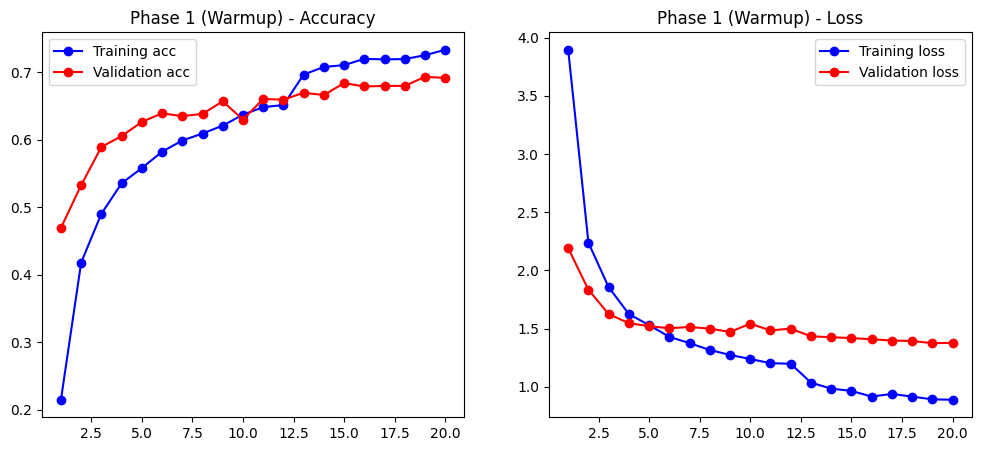

In [11]:
def plot_history(hist, phase_name):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
    plt.title(f'{phase_name} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title(f'{phase_name} - Loss')
    plt.legend()
    
    plt.show()

plot_history(history_1, "Phase 1 (Warmup)")

### 19. Retraining Phase 2 (Fine-tuning)
Finally, we unfreeze the top layers and fine-tune the model on the cleaned data, saving the final artifact as best_final_model_clean.h5.

In [ ]:
model.load_weights("best_phase1_clean.h5")
base_model.trainable = True

for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

for layer in base_model.layers[:-60]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

checkpoint2 = ModelCheckpoint("best_final_model_clean.h5", save_best_only=True)
early_stop = EarlyStopping(patience=9, restore_best_weights=True)
reduce_lr2 = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

history_2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint2, reduce_lr2]
)

Epoch 1/20
232/593 ━━━━━━━━━━━━━━━━━━━━ 3:36 599ms/step - accuracy: 0.7748 - loss: 0.7494

/home/user/tf_gpu_test/.venv/lib/python3.12/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.7717 - loss: 0.7444

593/593 ━━━━━━━━━━━━━━━━━━━━ 522s 764ms/step - accuracy: 0.7703 - loss: 0.7295 - val_accuracy: 0.7063 - val_loss: 1.3347 - learning_rate: 1.0000e-05
Epoch 2/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 368s 619ms/step - accuracy: 0.7714 - loss: 0.7305 - val_accuracy: 0.7063 - val_loss: 1.3381 - learning_rate: 1.0000e-05
Epoch 3/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 352s 592ms/step - accuracy: 0.7772 - loss: 0.7159 - val_accuracy: 0.7080 - val_loss: 1.3420 - learning_rate: 1.0000e-05
Epoch 4/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.7872 - loss: 0.6833

593/593 ━━━━━━━━━━━━━━━━━━━━ 401s 615ms/step - accuracy: 0.7791 - loss: 0.7247 - val_accuracy: 0.7063 - val_loss: 1.3328 - learning_rate: 1.0000e-05
Epoch 5/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.7785 - loss: 0.7167

593/593 ━━━━━━━━━━━━━━━━━━━━ 353s 594ms/step - accuracy: 0.7778 - loss: 0.7160 - val_accuracy: 0.7063 - val_loss: 1.3264 - learning_rate: 1.0000e-05
Epoch 6/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.7720 - loss: 0.7208

593/593 ━━━━━━━━━━━━━━━━━━━━ 345s 579ms/step - accuracy: 0.7787 - loss: 0.7191 - val_accuracy: 0.7046 - val_loss: 1.3249 - learning_rate: 1.0000e-05
Epoch 7/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 339s 571ms/step - accuracy: 0.7921 - loss: 0.6909 - val_accuracy: 0.7038 - val_loss: 1.3251 - learning_rate: 1.0000e-05
Epoch 8/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 337s 569ms/step - accuracy: 0.7928 - loss: 0.6849 - val_accuracy: 0.7089 - val_loss: 1.3270 - learning_rate: 1.0000e-05
Epoch 9/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.7816 - loss: 0.7121

593/593 ━━━━━━━━━━━━━━━━━━━━ 343s 579ms/step - accuracy: 0.7844 - loss: 0.6935 - val_accuracy: 0.7080 - val_loss: 1.3239 - learning_rate: 1.0000e-05
Epoch 10/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 341s 575ms/step - accuracy: 0.7952 - loss: 0.6766 - val_accuracy: 0.7105 - val_loss: 1.3279 - learning_rate: 1.0000e-05
Epoch 11/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 339s 572ms/step - accuracy: 0.7904 - loss: 0.6713 - val_accuracy: 0.7139 - val_loss: 1.3248 - learning_rate: 1.0000e-05
Epoch 12/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.7917 - loss: 0.6725

593/593 ━━━━━━━━━━━━━━━━━━━━ 346s 584ms/step - accuracy: 0.7941 - loss: 0.6752 - val_accuracy: 0.7105 - val_loss: 1.3233 - learning_rate: 1.0000e-05
Epoch 13/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.7893 - loss: 0.6807

593/593 ━━━━━━━━━━━━━━━━━━━━ 346s 583ms/step - accuracy: 0.7938 - loss: 0.6843 - val_accuracy: 0.7105 - val_loss: 1.3214 - learning_rate: 1.0000e-05
Epoch 14/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.7998 - loss: 0.6572

593/593 ━━━━━━━━━━━━━━━━━━━━ 354s 597ms/step - accuracy: 0.7984 - loss: 0.6653 - val_accuracy: 0.7148 - val_loss: 1.3168 - learning_rate: 1.0000e-05
Epoch 15/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.7998 - loss: 0.6474

593/593 ━━━━━━━━━━━━━━━━━━━━ 354s 597ms/step - accuracy: 0.8014 - loss: 0.6464 - val_accuracy: 0.7139 - val_loss: 1.3121 - learning_rate: 1.0000e-05
Epoch 16/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.7948 - loss: 0.6641

593/593 ━━━━━━━━━━━━━━━━━━━━ 345s 582ms/step - accuracy: 0.7937 - loss: 0.6642 - val_accuracy: 0.7148 - val_loss: 1.3082 - learning_rate: 1.0000e-05
Epoch 17/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.8050 - loss: 0.6567

593/593 ━━━━━━━━━━━━━━━━━━━━ 337s 567ms/step - accuracy: 0.8043 - loss: 0.6615 - val_accuracy: 0.7148 - val_loss: 1.3078 - learning_rate: 1.0000e-05
Epoch 18/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.8011 - loss: 0.6498

593/593 ━━━━━━━━━━━━━━━━━━━━ 342s 576ms/step - accuracy: 0.8015 - loss: 0.6496 - val_accuracy: 0.7165 - val_loss: 1.3071 - learning_rate: 1.0000e-05
Epoch 19/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 341s 575ms/step - accuracy: 0.8056 - loss: 0.6626 - val_accuracy: 0.7131 - val_loss: 1.3094 - learning_rate: 1.0000e-05
Epoch 20/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 343s 578ms/step - accuracy: 0.8023 - loss: 0.6435 - val_accuracy: 0.7139 - val_loss: 1.3094 - learning_rate: 1.0000e-05


### 20. Visualizing Final Retraining
We plot the final fine-tuning history to ensure convergence.

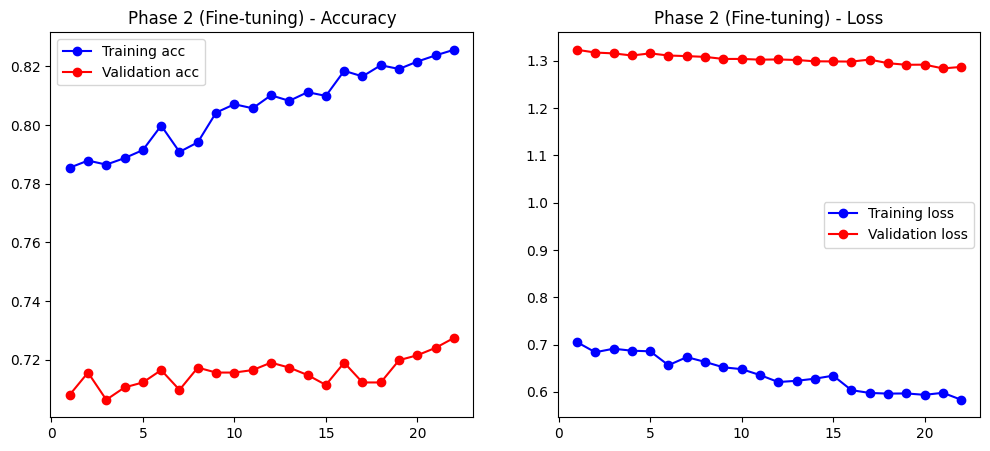

In [ ]:
def plot_history(hist, phase_name):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
    plt.title(f'{phase_name} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title(f'{phase_name} - Loss')
    plt.legend()
    
    plt.show()

plot_history(history_2, "Phase 2 (Fine-tuning)")

### 21. Final Evaluation (Cleaned Model)
We perform the final evaluation on the test set using the model trained on cleaned data. By comparing these metrics to the pre-cleaning metrics, we can quantify the improvement gained by removing the bad data.

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

model.load_weights("best_final_model_clean.h5")

y_true = test_ds.classes
y_pred_proba = model.predict(test_ds)
y_pred = np.argmax(y_pred_proba, axis=1)

macro_f1 = f1_score(y_true, y_pred, average="macro")
micro_f1 = f1_score(y_true, y_pred, average="micro")
weighted_f1 = f1_score(y_true, y_pred, average="weighted")

print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Micro F1-score: {micro_f1:.4f}")
print(f"Weighted F1-score: {weighted_f1:.4f}")

test_loss, test_acc = model.evaluate(test_ds)
print(f"Final Test Accuracy: {test_acc*100:.2f}%")

75/75 ━━━━━━━━━━━━━━━━━━━━ 38s 489ms/step
Macro F1-score: 0.7265
Micro F1-score: 0.7406
Weighted F1-score: 0.7391
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 385ms/step - accuracy: 0.7406 - loss: 1.3780
Final Test Accuracy: 74.06%


: 